Generative Adversarial Networks (GANs)are deep learning models that involve two neural networks: generator and a discriminator. These networks work in a setup where they are trained together in an adversarial manner.

The generator tries to generate fake data that is made from real data.
While the discriminator attempts to distinguish between real and fake data.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
from keras.layers import Input, Dense, Reshape, Flatten, Dropout 
from keras.layers import BatchNormalization, Activation, ZeroPadding2D 
from keras.layers import LeakyReLU 
from keras.layers import UpSampling2D, Conv2D 
from keras.models import Sequential, Model 
from keras.optimizers import Adam,SGD

Here we will loads the CIFAR-10 dataset and filters the images to only include a specific class (class 8).

In [3]:
(X, y), (_, _) = keras.datasets.cifar10.load_data() 

X = X[y.flatten() == 8]

Defining Input Shape and Latent Dimension
It defines the shape of the input image and the size of the latent vector.

image_shape: Defines the input image shape (32x32 with 3 color channels).
latent_dimensions: Specifies the size of the latent vector i.e noise input for the generator.

In [4]:
image_shape = (32, 32, 3)
latent_dimensions = 100

Building the Generator
It defines the generator which takes random noise as input and outputs an image.

Dense: A fully connected layer used to transform the latent vector into a higher-dimensional representation.
Reshape: Changes the shape of the output from Dense to make it suitable for convolution.
UpSampling2D: Upsamples the image to a higher resolution.
Conv2D: Convolutional layers to process the image and generate features.
Activation("tanh"): Activation function that ensures the pixel values of the generated image are in the range [-1, 1] using tanh.

In [5]:
def build_generator(): 
    model = Sequential() 

    model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dimensions)) 
    model.add(Reshape((8, 8, 128))) 

    model.add(UpSampling2D()) 
    model.add(Conv2D(128, kernel_size=3, padding="same")) 
    model.add(BatchNormalization(momentum=0.78)) 
    model.add(Activation("relu")) 

    model.add(UpSampling2D()) 
    model.add(Conv2D(64, kernel_size=3, padding="same")) 
    model.add(BatchNormalization(momentum=0.78)) 
    model.add(Activation("relu")) 

    model.add(Conv2D(3, kernel_size=3, padding="same")) 
    model.add(Activation("tanh")) 

    noise = Input(shape=(latent_dimensions,)) 
    image = model(noise) 

    return Model(noise, image)

Building the Discriminator
Here we will defines the discriminator which classifies images as real or fake.

Conv2D: Convolutional layers used to extract features from images.
LeakyReLU: An activation function that allows a small slope for negative values.
Dropout: A regularization technique that helps prevent overfitting.
Flatten: Flattens the image into a 1D vector for classification.
Dense: Fully connected layer to classify the image as real or fake.

In [6]:
def build_discriminator(): 
    model = Sequential() 

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same")) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dropout(0.25)) 
    
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same")) 
    model.add(ZeroPadding2D(padding=((0,1),(0,1)))) 
    model.add(BatchNormalization(momentum=0.82)) 
    model.add(LeakyReLU(alpha=0.25)) 
    model.add(Dropout(0.25)) 
    
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same")) 
    model.add(BatchNormalization(momentum=0.82)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dropout(0.25)) 
    
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same")) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(LeakyReLU(alpha=0.25)) 
    model.add(Dropout(0.25)) 
    
    model.add(Flatten()) 
    model.add(Dense(1, activation='sigmoid')) 

    image = Input(shape=image_shape) 
    validity = model(image) 

    return Model(image, validity)

In [7]:
def display_images(): 
    r, c = 4, 4
    noise = np.random.normal(0, 1, (r * c, latent_dimensions)) 
    generated_images = generator.predict(noise, verbose=0) 

    generated_images = 0.5 * generated_images + 0.5

    fig, axs = plt.subplots(r, c) 
    count = 0
    for i in range(r): 
        for j in range(c): 
            axs[i, j].imshow(generated_images[count, :, :, :]) 
            axs[i, j].axis('off') 
            count += 1
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show() 
    plt.close()

We will build and compile the discriminator and freezes its weights for the combined model training.

Adam(0.0002, 0.5): Adam optimizer with specific learning rate and beta values.
We will be using binary crossentropy for loss calculation.
trainable = False: Freezes the weights of the discriminator so that only the generator gets trained during the combined model's training.

In [8]:
discriminator = build_discriminator() 
discriminator.compile(loss='binary_crossentropy', 
                    optimizer=Adam(0.0002, 0.5), 
                    metrics=['accuracy'])

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1770908120.368523  250019 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14793 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5
/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


We will create combined GAN model by connecting the generator and discriminator.

combined_network: A model that takes noise as input, generates an image and then checks if the image is real or fake using the discriminator.

In [9]:
generator = build_generator() 

z = Input(shape=(latent_dimensions,)) 
image = generator(z) 

# Freeze discriminator layers for the combined model
for layer in discriminator.layers:
    layer.trainable = False

validity = discriminator(image) 
combined_network = Model(z, validity) 
combined_network.compile(loss='binary_crossentropy', 
                        optimizer=Adam(0.0002, 0.5))

# Unfreeze and recompile discriminator for standalone training
for layer in discriminator.layers:
    layer.trainable = True
discriminator.compile(loss='binary_crossentropy', 
                    optimizer=Adam(0.0002, 0.5), 
                    metrics=['accuracy'])

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We will train the GAN by alternating between training the discriminator and generator.

train_on_batch: Trains the models on a single batch of data.
discriminator.train_on_batch: Trains the discriminator on real and fake images.
combined_network.train_on_batch: Trains the generator to produce images that can fool the discriminator.
We will be using batch size of 32.
We will be using 12,500 epochs for training and will display outputs after every 2500 epochs to see difference.

I0000 00:00:1770908121.909260  250092 service.cc:152] XLA service 0x72004c004b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770908121.909287  250092 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2026-02-12 14:55:21.924484: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1770908121.964593  250092 cuda_dnn.cc:529] Loaded cuDNN version 90501
2026-02-12 14:55:22.082031: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.9 = (f32[32,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,16,16]{3,2,1,0} %bitcast.299, f32[128,128,3,3]{3,2,1,0} %bitcast.306, f32[128]{0} %bitcast.308), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBi

Epoch 0 — D loss: 1.1158, D acc: 0.0%, G loss: 0.7349


2026-02-12 14:55:41.177461: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.9 = (f32[16,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,16,16]{3,2,1,0} %bitcast.299, f32[128,128,3,3]{3,2,1,0} %bitcast.306, f32[128]{0} %bitcast.308), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_31_1/sequential_1_1/conv2d_4_1/convolution" source_file="/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2026-02-12 14:55:41.278389: I external/local_xla/xla/service/gpu/autotuning/conv_algo

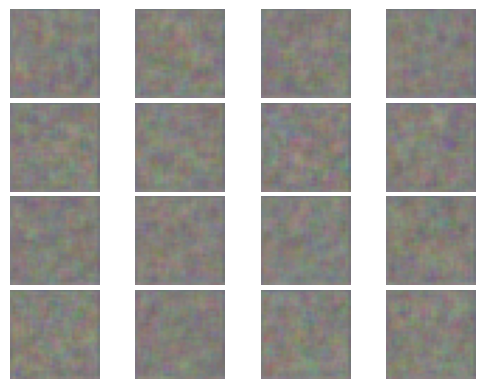

Epoch 2500 — D loss: 0.7814, D acc: 0.0%, G loss: 0.7545


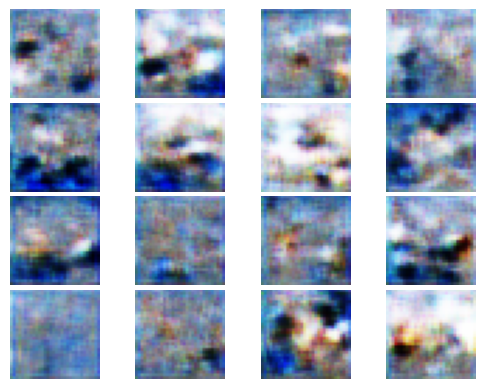

Epoch 5000 — D loss: 0.8125, D acc: 0.0%, G loss: 0.6926


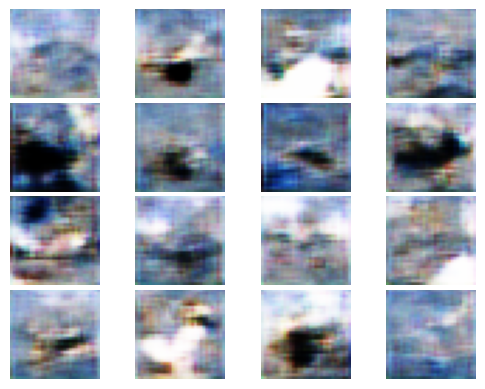

Epoch 7500 — D loss: 0.8396, D acc: 0.0%, G loss: 0.6567


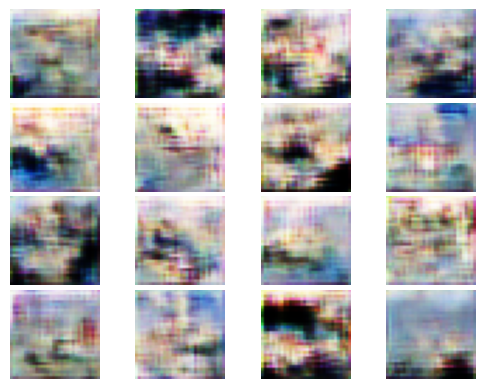

Epoch 10000 — D loss: 0.8763, D acc: 0.0%, G loss: 0.6301


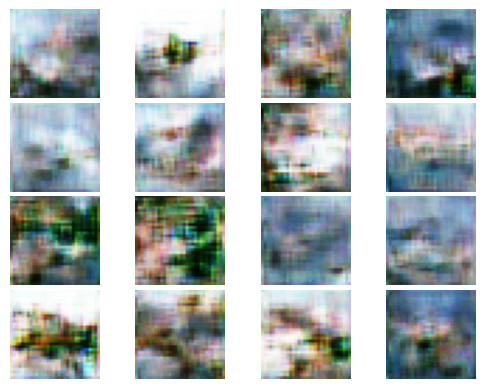

In [10]:
num_epochs = 12500
batch_size = 32
display_interval = 2500

X = (X / 127.5) - 1.

for epoch in range(num_epochs): 
    # --- Train Discriminator ---
    index = np.random.randint(0, X.shape[0], batch_size) 
    images = X[index] 

    noise = np.random.normal(0, 1, (batch_size, latent_dimensions)) 
    generated_images = generator.predict(noise, verbose=0) 

    # Fresh soft labels each step
    valid_labels = np.random.uniform(0.7, 1.0, (batch_size, 1))
    fake_labels = np.random.uniform(0.0, 0.3, (batch_size, 1))

    discm_loss_real = discriminator.train_on_batch(images, valid_labels) 
    discm_loss_fake = discriminator.train_on_batch(generated_images, fake_labels) 
    discm_loss = 0.5 * np.add(discm_loss_real, discm_loss_fake) 
    
    # --- Train Generator (discriminator frozen in combined model) ---
    noise = np.random.normal(0, 1, (batch_size, latent_dimensions))
    genr_loss = combined_network.train_on_batch(noise, np.ones((batch_size, 1))) 
    
    if epoch % display_interval == 0: 
        print(f"Epoch {epoch} — D loss: {discm_loss[0]:.4f}, D acc: {100*discm_loss[1]:.1f}%, G loss: {genr_loss:.4f}")
        display_images()